# Equalized Odds

### Dataset
Using adult income dataset from UCI repo provided by shap library.

### Definition
Adds conditioning on label compared to Demographic parity, i.e.

Mathematically:
$ratio <= \frac{P[h(X) = y' | A = a, Y = y]}{P[h(X) = y' | Y = y]} <= \frac{1}{ratio}, \forall a, y, y'$

In [1]:
import numpy as np
import pandas as pd

import shap
shap.initjs()

from fairlearn.reductions import ExponentiatedGradient
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

In [2]:
X, Y = shap.datasets.adult()
sensitive_attribute = 'Sex'

A = X[sensitive_attribute]
X = pd.get_dummies(X)

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

le = LabelEncoder()
Y = le.fit_transform(Y)

X = X.reset_index(drop=True)
A = A.reset_index(drop=True)

In [3]:
class LeastSquaresBinaryClassifierLearner:
    def __init__(self):
        self.weights = None

    def fit(self, X, Y, sample_weight):
        sqrtW = np.sqrt(sample_weight)
        matX = np.array(X) * sqrtW[:, np.newaxis]
        vecY = Y * sqrtW
        self.lsqinfo = np.linalg.lstsq(matX, vecY, rcond=-1)
        self.weights = pd.Series(self.lsqinfo[0], index=list(X))

    def predict(self, X):
        pred = X.dot(np.asarray(self.weights))
        return 1 * (pred > 0.5)

In [4]:
unmitigated_predictor = LeastSquaresBinaryClassifierLearner()
unmitigated_predictor.fit(X, Y, sample_weight=[1])

In [5]:
from fairlearn.reductions import EqualizedOdds, ErrorRate

def Unmit(X): return unmitigated_predictor.predict(X)
# violation
disparity_moment = EqualizedOdds()
disparity_moment.load_data(X, Y, sensitive_features=A)
eo_violation_unmitigated = disparity_moment.gamma(Unmit).max()

# error
error = ErrorRate()
error.load_data(X, Y, sensitive_features=A)
eo_error_unmitigated = error.gamma(Unmit)[0]

# Experiment 1 - Calculating violation by varying epsilon 

In [6]:
# Experiment 1 - Calculating violation by varying epsilon 
eps_list = [0.001, 0.005, 0.01, 0.05, 0.1]
eo_expgrad_error = []
eo_expgrad_violation = []
eo_best_gap = []

estimator = LeastSquaresBinaryClassifierLearner()
for eps in eps_list:
    expgrad_X = ExponentiatedGradient(estimator,
                                      constraints=EqualizedOdds(),
                                      eps=eps, nu=1e-6)
    
    expgrad_X.fit(X, Y, sensitive_features=A)

    def Q(X): return expgrad_X._pmf_predict(X)[:, 1]
    # violation
    disparity_moment = EqualizedOdds()
    disparity_moment.load_data(X, Y, sensitive_features=A)
    disparity = disparity_moment.gamma(Q).max()
    
    # error
    error = ErrorRate()
    error.load_data(X, Y, sensitive_features=A)
    error = error.gamma(Q)[0]
    
    eo_expgrad_violation.append(disparity)
    eo_expgrad_error.append(error)
    eo_best_gap.append(expgrad_X._best_gap)

In [7]:
print('{}\t\t{}\t\t\t{}\t\t\t{}'.format('Epsilon', 'Max Violation', 'Error', 'Best Gap'))
for i in range(len(eps_list)):
    print('{}\t\t{}\t\t{}\t{}'.format(eps_list[i], eo_expgrad_violation[i],
                                  eo_expgrad_error[i], eo_best_gap[i]))
print('{}\t\t{}\t\t{}\t{}'.format('Unmit.', eo_violation_unmitigated,
                              eo_error_unmitigated, '-'))

Epsilon		Max Violation			Error			Best Gap
0.001		0.0010000000000050524		0.20019384769282705	2.4175106361212784e-14
0.005		0.005000000000002891		0.19819567414260644	2.6367796834847468e-14
0.01		0.009999999999999995		0.19576883422408073	2.6922908347160046e-15
0.05		0.04999999999999999		0.19399144116186282	2.7755575615628914e-17
0.1		0.09365669829506912		0.194005098123522	0.0
Unmit.		0.09365669829506912		0.194005098123522	-


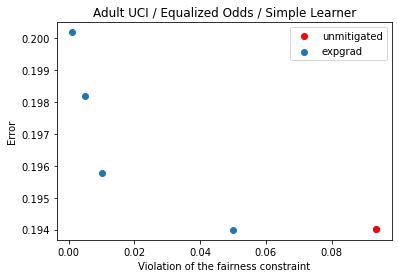

In [8]:
import matplotlib.pyplot as plt

plt.scatter(eo_expgrad_violation, eo_expgrad_error, label="expgrad")
plt.plot(eo_violation_unmitigated, eo_error_unmitigated, 'ro', label="unmitigated")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult UCI / Equalized Odds / Simple Learner')
plt.legend()
plt.show()

# Experiment 2 - Calculating violation by varying epsilon and ratio

In [9]:
# Experiment 2 - Calculating violation by varying epsilon 
from fairlearn.reductions import EqualizedOdds

ratio_list = [0.8, 0.85, 0.9, 0.95, 1.0]
eps_list = [0.001, 0.005, 0.01, 0.05, 0.1]

ratio_to_violation = {}
ratio_to_error = {}
ratio_to_unmitigated_eo_violation = {}
ratio_to_best_gap = {}
for ratio in ratio_list:
    eo_expgrad_error = []
    eo_expgrad_violation = []
    eo_best_gap = []
    estimator = LeastSquaresBinaryClassifierLearner()

    for eps in eps_list:
        expgrad_X = ExponentiatedGradient(estimator,
                                          constraints=EqualizedOdds(ratio=ratio),
                                          eps=eps, nu=1e-6)

        expgrad_X.fit(X, Y, sensitive_features=A)

        def Q(X): return expgrad_X._pmf_predict(X)[:, 1]
        # violation
        disparity_moment = EqualizedOdds(ratio=ratio)
        disparity_moment.load_data(X, Y, sensitive_features=A)
        disparity = disparity_moment.gamma(Q).max()

        # error
        error = ErrorRate()
        error.load_data(X, Y, sensitive_features=A)
        error = error.gamma(Q)[0]

        eo_expgrad_violation.append(disparity)
        eo_expgrad_error.append(error)
        eo_best_gap.append(expgrad_X._best_gap)
    
    ratio_to_violation[ratio] = eo_expgrad_violation
    ratio_to_error[ratio] = eo_expgrad_error
    ratio_to_best_gap[ratio] = eo_best_gap
    
    # Unmit.
    def Unmit(X): return unmitigated_predictor.predict(X)
    # violation
    disparity_moment = EqualizedOdds(ratio=ratio)
    disparity_moment.load_data(X, Y, sensitive_features=A)
    eo_violation_unmitigated = disparity_moment.gamma(Unmit).max()
    ratio_to_unmitigated_eo_violation[ratio] = eo_violation_unmitigated
    
# error of unmit.
error = ErrorRate()
error.load_data(X, Y, sensitive_features=A)
eo_error_unmitigated = error.gamma(Unmit)[0]

In [10]:
for ratio in ratio_list:
    print('Ratio: {}'.format(ratio))
    eo_expgrad_violation = ratio_to_violation[ratio]
    eo_expgrad_error = ratio_to_error[ratio]
    eo_best_gap = ratio_to_best_gap[ratio]
    print('{}\t\t{}\t\t\t{}\t\t\t{}'.format('Epsilon', 'Max Violation', 'Error', 'Best Gap'))
    for i in range(len(eps_list)):
        print('{}\t\t{}\t\t{}\t{}'.format(eps_list[i], eo_expgrad_violation[i],
                                      eo_expgrad_error[i], eo_best_gap[i]))

    print('{}\t\t{}\t\t{}\t{}'.format('Unmit.', ratio_to_unmitigated_eo_violation[ratio],
                                  eo_error_unmitigated, '-'))

Ratio: 0.8
Epsilon		Max Violation			Error			Best Gap
0.001		0.001000000000000209		0.19556141298992133	1.7486012637846216e-15
0.005		0.004999999999999987		0.19498820132223124	4.3520742565306136e-14
0.01		0.010000000000000165		0.19437548966857038	1.6819878823071122e-14
0.05		0.032516537601280066		0.194005098123522	0.0
0.1		0.032516537601280066		0.194005098123522	0.0
Unmit.		0.032516537601280066		0.194005098123522	-
Ratio: 0.85
Epsilon		Max Violation			Error			Best Gap
0.001		0.0010000000000012221		0.1950100566239693	1.2034817586936697e-13
0.005		0.005000000000000098		0.19522031156232428	2.4424906541753444e-14
0.01		0.010000000000000064		0.19473525654246812	2.220446049250313e-15
0.05		0.04780157777472732		0.194005098123522	0.0
0.1		0.04780157777472732		0.194005098123522	0.0
Unmit.		0.04780157777472732		0.194005098123522	-
Ratio: 0.9
Epsilon		Max Violation			Error			Best Gap
0.001		0.0010000000000003756		0.19655812836960793	2.2648549702353193e-14
0.005		0.004999999999999952		0.195715129745

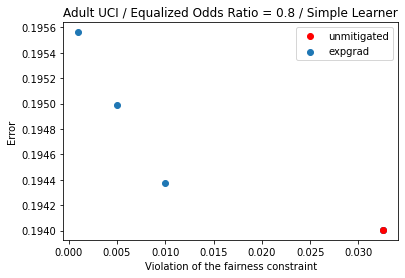

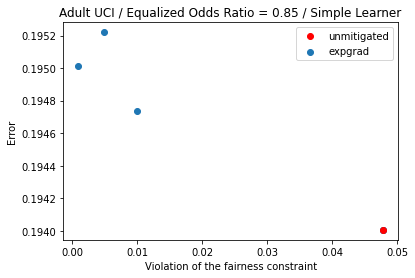

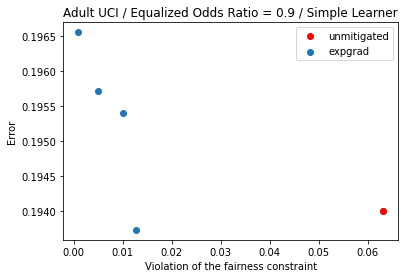

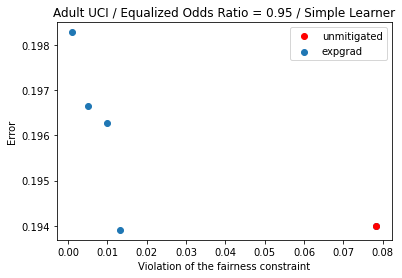

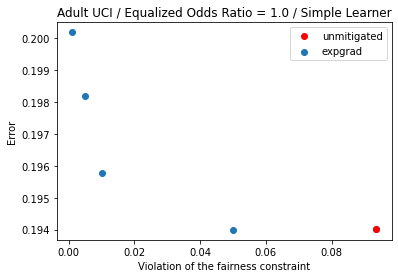

In [11]:
import matplotlib.pyplot as plt

for ratio in ratio_list:
    eo_expgrad_violation = ratio_to_violation[ratio]
    expgrad_error = ratio_to_error[ratio]
    
    plt.scatter(eo_expgrad_violation, expgrad_error, label="expgrad")
    plt.plot([ratio_to_unmitigated_eo_violation[ratio]], eo_error_unmitigated, 'ro',
             label="unmitigated")
    plt.xlabel('Violation of the fairness constraint')
    plt.ylabel('Error')
    plt.title('Adult UCI / Equalized Odds Ratio = {} / Simple Learner'.format(ratio))
    plt.legend()
    plt.show()